### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#imports
import scipy.io
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import obspy
import pywt
import pywt.data

### Load the trimmed data 

In [3]:
path = "/Users/ecem/Desktop/phonocardiogram/data/PV/present"
path_w = "/Users/ecem/Desktop/phonocardiogram/data/wavelet_4"
waves = np.load(path + "/present_PV_waves_10sec.npy", allow_pickle= True)

In [4]:
waves.shape

(1198, 40000)

## Let's look at wavelet decomposition for a signal piece

#### how our decomposition filter values look like

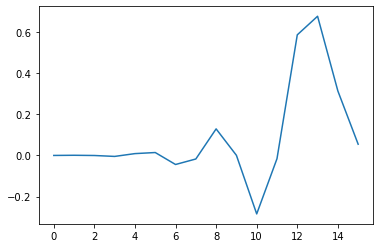

In [5]:
w = pywt.Wavelet('db8')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(waves[0], w, level=6)

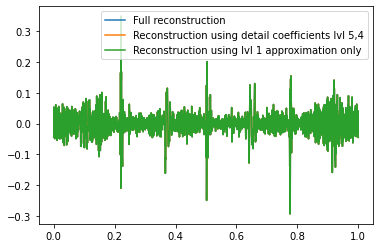

In [6]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(pywt.waverec(coeffs, w)) # full reconstruction 
reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, w)) # leaving out detail coefficients up to lvl 5
reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, w)) # leaving out detail coefficients up to lvl 4
#reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, w)) # leaving out detail coefficients up to lvl 3
#reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, w)) # leaving out detail coefficients up to lvl 2
#reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, w)) # leaving out detail coefficients up to lvl 1
#reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, w)) # leaving out all detail coefficients = reconstruction using lvl1 approximation only
plt.legend(['Full reconstruction', 'Reconstruction using detail coefficients lvl 5,4', 'Reconstruction using lvl 1 approximation only'])

Amplitude of the coefficient corresponds to amplitude with which the wavelet occurs in the signal (y axis), and position of the coefficient corresponds to the time (x axis). 

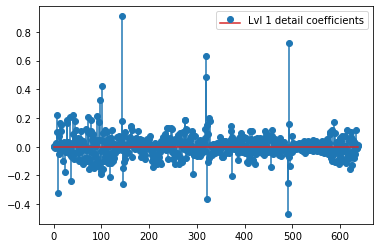

In [7]:
plt.stem(coeffs[1]); plt.legend(['Lvl 1 detail coefficients'])

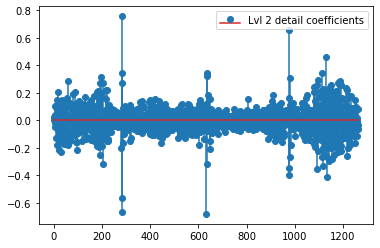

In [8]:
plt.stem(coeffs[2]); plt.legend(['Lvl 2 detail coefficients'])


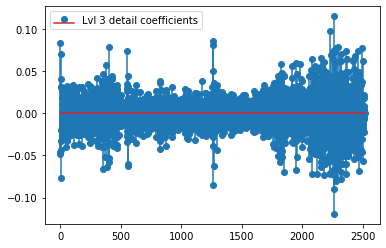

In [9]:
plt.stem(coeffs[3]); plt.legend(['Lvl 3 detail coefficients'])


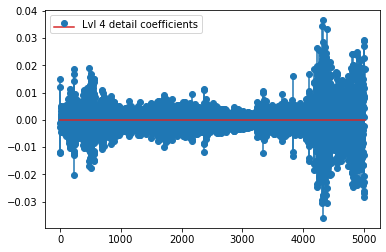

In [10]:
plt.stem(coeffs[4]); plt.legend(['Lvl 4 detail coefficients'])


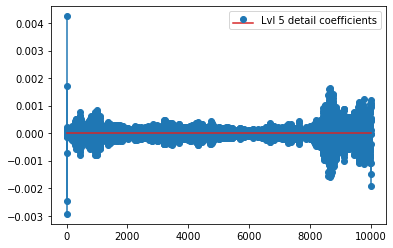

In [11]:
plt.stem(coeffs[5]); plt.legend(['Lvl 5 detail coefficients'])


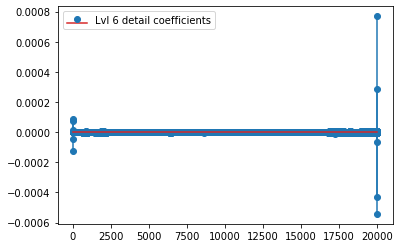

In [12]:
plt.stem(coeffs[6]); plt.legend(['Lvl 6 detail coefficients'])

In [13]:
# Reconstruction of signal using just lvl1 approximation
approx_lvl1 = pywt.waverec(coeffs[:-6] + [None] * 6, w)
# interpolate to original amount of samples (necessary due to numeric solution of transformation not yielding same amount of values)
approx_lvl1_interp = np.interp(x=np.arange(0, len(waves[0])), xp=np.linspace(0, 525, len(approx_lvl1)), fp=approx_lvl1)
x_without_lvl1approx = waves[0] - approx_lvl1_interp

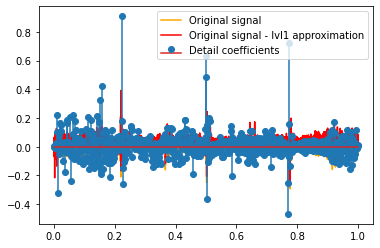

In [14]:
def reconstruction_stem(yyy, **kwargs):
    """Plot coefficient vector on x [0,1] independently of amount of values it contains."""
    plt.stem(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(waves[0], color='orange')
reconstruction_plot(x_without_lvl1approx, color='red')
reconstruction_stem(coeffs[1])
plt.legend(['Original signal', 'Original signal - lvl1 approximation', 'Detail coefficients'])

In [15]:
import pandas as pd

In [16]:
coef = []
for i in range(len(waves)):
    coef.append(pywt.wavedec(waves[i], w, level=5))

In [17]:
for i in range(6):
    print(coef[0][i].shape)

(1264,)
(1264,)
(2514,)
(5013,)
(10011,)
(20007,)


In [18]:
coef[0]

[array([ 0.02258693,  0.00933716,  0.00092998, ...,  0.02981981,
        -0.18617724, -0.33717698], dtype=float32),
 array([ 0.00415235,  0.00603118,  0.02500038, ...,  0.08535182,
        -0.0354794 , -0.06699299], dtype=float32),
 array([-0.04885083,  0.08393421, -0.04534097, ..., -0.0067741 ,
         0.00465053,  0.00084757], dtype=float32),
 array([-0.00249927,  0.01196737, -0.0123217 , ...,  0.02713388,
        -0.02681288,  0.01870261], dtype=float32),
 array([-0.00245634,  0.00424416, -0.00293412, ..., -0.00149906,
         0.00043899,  0.00096521], dtype=float32),
 array([ 7.3189811e-05, -1.2432328e-04,  8.3934458e-05, ...,
        -6.8835609e-05, -4.3944424e-06, -3.6834313e-06], dtype=float32)]

In [19]:
coef[1]

[array([-0.05977475, -0.06602652, -0.07161645, ..., -0.05743887,
        -0.03404463, -0.02539658], dtype=float32),
 array([ 0.00357159,  0.0054036 ,  0.021128  , ..., -0.01570009,
         0.01427532,  0.04546291], dtype=float32),
 array([-0.04189866,  0.06633293, -0.04799371, ...,  0.01135873,
         0.00444665, -0.00164698], dtype=float32),
 array([ 0.01854473, -0.02524492,  0.00988635, ..., -0.00041482,
        -0.00189817,  0.0039638 ], dtype=float32),
 array([-2.0023093e-03,  5.8212590e-05,  1.3413506e-03, ...,
        -5.3935059e-05, -1.2218351e-04,  4.8962196e-05], dtype=float32),
 array([ 4.2839281e-04, -7.6302222e-04,  5.5524177e-04, ...,
        -3.5953319e-05,  4.5118691e-07,  1.6494296e-06], dtype=float32)]

### Level by level

In [20]:
def level_coef_extractor_3d(array, lvl = 0):
    array =np.array(array)
    
    lenn = array[0][lvl].shape[0] #48
    coef = np.ones(shape = (array.shape[0],lenn)) #2392,48
    
    for i in range(array.shape[0]):
        coef[i,:] = array[i][lvl]
        
    return coef

In [21]:
def saver(array = 0, lvl = 0, dir_path = None, name = 'blank'):
    coefs = level_coef_extractor_3d(array, lvl)
    np.save(dir_path + "/"+ str(name) + "_lvl_"  + str(lvl), coefs, allow_pickle = True)
    del coefs

In [22]:
for i in range(6):
    saver(coef, i, path_w, 'present_PV_wavelet_coef_5')


In [23]:
waves_ = np.load(path_w+ "/present_PV_wavelet_coef_5_lvl_0.npy",  allow_pickle = True)

In [24]:
waves_.shape

(1198, 1264)

In [25]:
waves_[0]

array([ 0.02258693,  0.00933716,  0.00092998, ...,  0.02981981,
       -0.18617724, -0.33717698])

In [26]:
waves_[10]

array([-0.09657948, -0.09660367, -0.09396319, ...,  0.0472011 ,
       -0.03135601, -0.06629197])